## Framework and Interfaces of this project

This project is using modular design paradigm, i.e., using functions instead of classes.

The whole project includes following vital components.

1. **Triming Component: This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.**
    
    **Function example: new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)**
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, length, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, length, height)

2. **Tower Generating Component: This component generates a random tower.**

    **Function example: new_tower = commNetGenTower(total_area)**

    Inputs:
        total_area: a tuple of 2 integers, (total_length, total_height).
    
    Outputs:
        new_tower: a tuple of 4 integers, (left_up_x, left_up_y, length, height)
    
3. **Drawing Component: This component is for printing a colorful map of trimmed towers given a sequence of trimmed tower areas.**
    
    **Function example: net_patches = commNetDraw(trimmed_towers, total_area)**
    
    Inputs: 
        1. trimmed_towers: A list of tuples of 4 integers(left_up_x, left_up_y, length, height), representing trimmed tower areas.
        2. total_area: a tuple of 2 integers, (total_length, total_height).
    
    Output:
        net_patches: A matplotlib figure with different colors representing areas covered by different towers.
        (Optional): A animation, that the plotting pauses once a new tower area is plotted.

4. **Gluing Component: Gluing the previous three components and construct a pipeline**

    **Function example: trimmed_towers, net_patches = commNetMain(total_area, given_towers)**
    
    Inputs: 
        1. given_towers: A list of tuples of 4 integers(left_up_x, left_up_y, length, height), representing given tower areas.
        2. total_area: a tuple of 2 integers, (total_length, total_height).
    
    Output:
        1. net_patches: A matplotlib figure with different colors representing areas covered by different towers.
        2. trimmed_towers: A list of tuples of 4 integers(left_up_x, left_up_y, length, height), representing trimmed tower areas.
        
5. **Utilities**:
    1. Generating total area
    2. Counting covered area
    3. Judge if all area is covered
    
6. **Testing Components**: 
    1. Function to test problem 1: Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?
    2. Function to test problem 2: What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?
    3. Function to test problem 3: On average, how many communications towers are required before full coverage is obtained?

### Triming Component:

#### This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.

    **Function example: new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)**
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, length, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, length, height)



In [19]:
import numpy as np
import matplotlib.pyplot as plt

### Tower Generating Component: This component generates a random tower.

    **Function example: new_tower = commNetGenTower(total_area)**

    Inputs:
        total_area: a tuple of 2 integers, (total_length, total_height).
    
    Outputs:
        new_tower: a tuple of 4 integers, (left_up_x, left_up_y, length, height)

In [14]:
def commNetGenTower(total_area):
    """
    Generates a random tower.
    
    Inputs:
    total_area: a tuple of 2 integers, (total_width, total_height).

    Outputs:
    new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    """
    total_width, total_height = total_area
    left_up_x = np.random.randint(0, total_width)
    left_up_y = np.random.randint(0, total_height)
    width = np.random.randint(1, total_width-left_up_x+1)
    height = np.random.randint(1, total_height-left_up_y+1)
    new_tower = (left_up_x, left_up_y, width, height)
    
    return new_tower

In [25]:
for i in range(3):
    print commNetGenTower(total_area)

(3, 5, 7, 9)
(3, 1, 7, 11)
(2, 12, 7, 1)


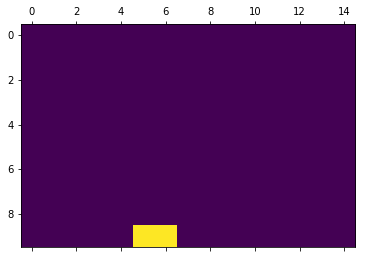

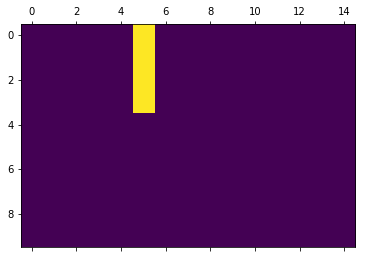

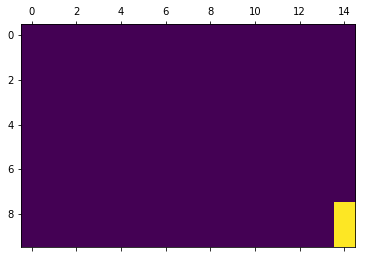

In [23]:
# Test commNetGenTower(total_area)
total_area = (10, 15)
for i in range(3):
    new_tower = commNetGenTower(total_area)
    (left_up_x, left_up_y, width, height) = new_tower
    old_map = np.zeros(total_area)
    new_map = np.copy(old_map)
    new_map[left_up_x : left_up_x+width, left_up_y : left_up_y+height] += 1 
    plt.matshow(new_map)